# Time Series using ARIMA model

##### Auto Regressive Differencing Moving Average Model

Time Series is powerful method to visualize the data collected for a period of time. They help us in knowing the trends and patterns of data over time

### Import Libraries

In [288]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings        
warnings.filterwarnings("ignore")
import os
import plotly.express as px 
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object
from statsmodels.tsa.seasonal import * 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from sklearn.model_selection import TimeSeriesSplit

### Load Operations, Weather and Weather Station Data

In [2]:
data_aerial = pd.read_csv('.././csv/operations.csv')
df_aerial = pd.DataFrame(data=data_aerial)
data_wstation = pd.read_csv('.././csv/Weather Station Locations.csv')
df_wstation = pd.DataFrame(data=data_wstation)
data_weather = pd.read_csv('.././csv/Summary of Weather.csv')
df_weather = pd.DataFrame(data=data_weather)

In [4]:
df_aerial.head(5)

,Mission ID,Mission Date,Theater of Operations,Country,Air Force,Unit ID,Aircraft Series,Callsign,Mission Type,Takeoff Base,...,Incendiary Devices Weight (Tons),Fragmentation Devices,Fragmentation Devices Type,Fragmentation Devices Weight (Pounds),Fragmentation Devices Weight (Tons),Total Weight (Pounds),Total Weight (Tons),Time Over Target,Bomb Damage Assessment,Source ID
0,1,8/15/1943,MTO,USA,12 AF,27 FBG/86 FBG,A36,NaN,NaN,PONTE OLIVO AIRFIELD,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
1,2,8/15/1943,PTO,USA,5 AF,400 BS,B24,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,9366.0
2,3,8/15/1943,MTO,USA,12 AF,27 FBG/86 FBG,A36,NaN,NaN,PONTE OLIVO AIRFIELD,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
3,4,8/15/1943,MTO,USA,12 AF,27 FBG/86 FBG,A36,NaN,NaN,PONTE OLIVO AIRFIELD,...,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,NaN
4,5,8/15/1943,PTO,USA,5 AF,321 BS,B24,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,22585.0


In [140]:
df_wstation.head(5)

,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


In [141]:
df_weather.head(5)

,STA,Date,MeanTemp
0,10001,1942-07-01,23.888889
1,10001,1942-07-02,25.555556
2,10001,1942-07-03,24.444444
3,10001,1942-07-04,24.444444
4,10001,1942-07-05,24.444444


## Exploratory Data Analysis

##### Select only required columns for Model

In [17]:
df_aerial = df_aerial[['Mission Date', 'Theater of Operations', 'Country',
       'Air Force',  'Aircraft Series', 'Callsign', 'Mission Type',
       'Takeoff Base', 'Takeoff Location', 'Takeoff Latitude',
       'Takeoff Longitude',  'Target Country', 'Target City',
       'Target Type', 'Target Industry', 'Target Priority', 'Target Latitude',
       'Target Longitude'       
       ]]
df_wstation = df_wstation.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"] ]
df_weather = df_weather.loc[:,["STA","Date","MeanTemp"] ]

##### Dropping the Null records

In [10]:
df_aerial = df_aerial[pd.isna(df_aerial.Country)==False]
df_aerial = df_aerial[pd.isna(df_aerial['Target Longitude'])==False]    
df_aerial = df_aerial[pd.isna(df_aerial['Takeoff Longitude'])==False] 

##### Converting the object column to Date column

In [26]:
df_aerial['Mission Date'] = pd.to_datetime(df_aerial['Mission Date'])
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [18]:
df_aerial.shape

(2942, 18)

##### Visualizing the no. of attacks country wise

Country
USA              1895
GREAT BRITAIN     931
NEW ZEALAND       102
SOUTH AFRICA       14
Name: count, dtype: int64


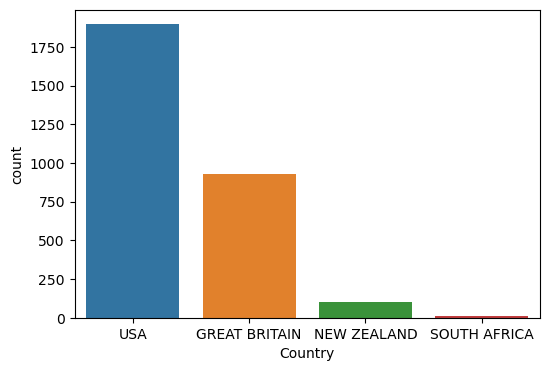

In [13]:
print(df_aerial['Country'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(df_aerial, x='Country')
plt.show()

##### How many mission carried out on different dates

<Axes: xlabel='Mission Date'>

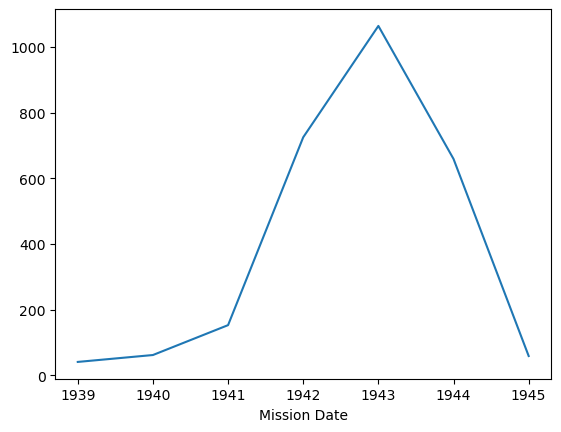

In [293]:
df_aerial[['Mission Date', 'Theater of Operations']].groupby(df_aerial['Mission Date'].dt.year)['Theater of Operations'].count().plot()

In [54]:
df_aerial.columns,df_weather.columns,df_wstation.columns

(Index(['Mission Date', 'Theater of Operations', 'Country', 'Air Force',
        'Aircraft Series', 'Callsign', 'Mission Type', 'Takeoff Base',
        'Takeoff Location', 'Takeoff Latitude', 'Takeoff Longitude',
        'Target Country', 'Target City', 'Target Type', 'Target Industry',
        'Target Priority', 'Target Latitude', 'Target Longitude', 'color'],
       dtype='object'),
 Index(['STA', 'Date', 'MeanTemp'], dtype='object'),
 Index(['WBAN', 'NAME', 'STATE/COUNTRY ID', 'Latitude', 'Longitude'], dtype='object'))

##### Visualizing rhe No. of attacks on different targets

In [37]:
df_aerial['color'] = ''
df_aerial.color[df_aerial.Country == 'USA'] = 'rgb(0,116,217)'
df_aerial.color[df_aerial.Country == 'GREAT BRITAIN'] = 'rgb(255,65,54)'
df_aerial.color[df_aerial.Country == 'NEW ZEALAND'] = 'rgb(133,20,75)'
df_aerial.color[df_aerial.Country == 'SOUTH AFRICA'] = 'rgb(255,133,27)'

In [142]:
fig = px.scatter_geo(df_aerial, lat='Target Latitude', lon='Target Longitude', color='Country',
                     hover_name=df_aerial['Mission Date'].dt.year, 
                     title='Attacks')
fig.show()

##### No. of Weather Stations accross different Countries

In [52]:
fig = px.scatter_geo(df_wstation, lat='Latitude', lon='Longitude', color='STATE/COUNTRY ID',
                     hover_name=df_wstation['NAME'], 
                     title='Attacks')
fig.show()

##### Taking only a subset of data for timeseries Analysis

Mean Temperature @ KATHA and at what temperature the attack had occured

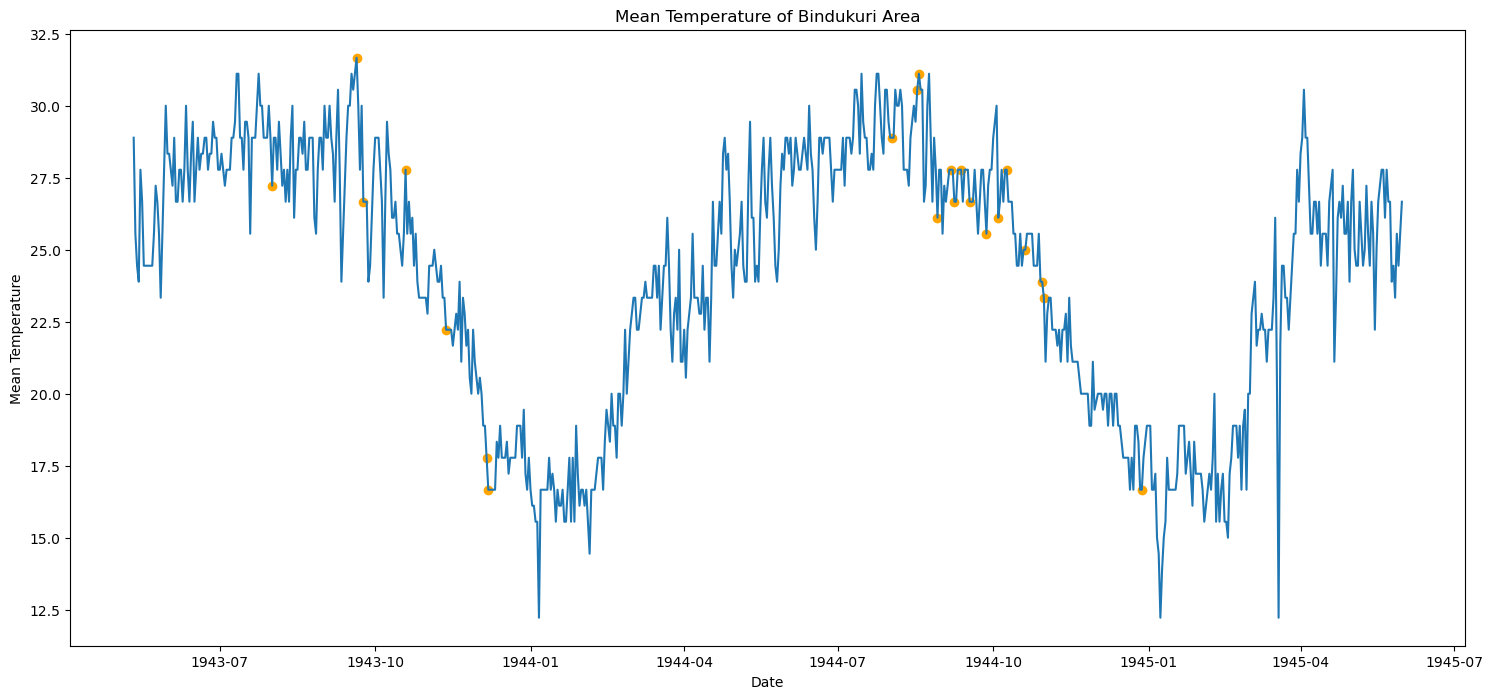

In [184]:
# Fetch the weather station id
station_id = df_wstation[df_wstation['NAME'] == 'BINDUKURI']['WBAN']
Burma_station = df_weather[df_weather['STA']==station_id.iloc[0]]
# Get war Dates
df_war = pd.read_csv('.././csv/operations.csv')
df_war['year'] = pd.to_datetime(df_war['Mission Date']).dt.year 
df_war['month'] = pd.to_datetime(df_war['Mission Date']).dt.month 
df_war = df_war[(df_war['Country']=='USA')&(df_war['Target City']=='KATHA')&(df_war['year']>=1943)&(df_war['month']>=8)] 
df_war = Burma_station[Burma_station['Date'].isin(df_war['Mission Date'])]
# Plot Date Vs Mean Temp
plt.figure(figsize=(18,8))
plt.scatter(df_war['Date'],df_war['MeanTemp'],color='orange')
plt.plot(Burma_station['Date'],Burma_station['MeanTemp'])
plt.title('Mean Temperature of Bindukuri Area')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

## Stationarity of a Time Series

##### Mean = Standard Deviation
Removing all seasonality and trends to make the data stable

### Taking the subset of data of Burma Station

In [160]:
ts_Burma_station = Burma_station.iloc[:,1:]
ts_Burma_station.index = Burma_station['Date']
ts_Burma_station.drop('Date',axis=1,inplace=True)
ts_Burma_station

,MeanTemp
Date,
1943-05-11,28.888889
1943-05-12,25.555556
1943-05-13,24.444444
1943-05-14,23.888889
1943-05-15,27.777778
...,...
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444


### Checking Seasonality and Trend

<Axes: xlabel='Date'>

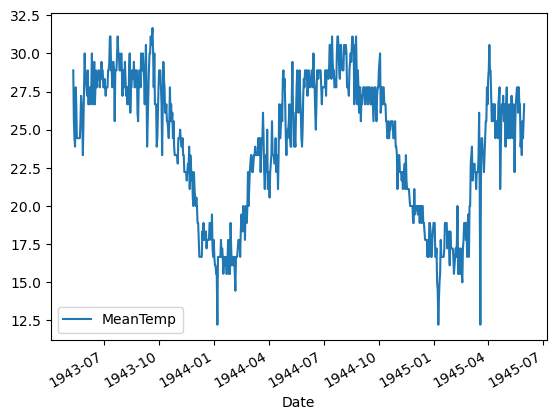

In [185]:
ts_Burma_station.plot()

##### Decomposing to view Seasonality & Trend

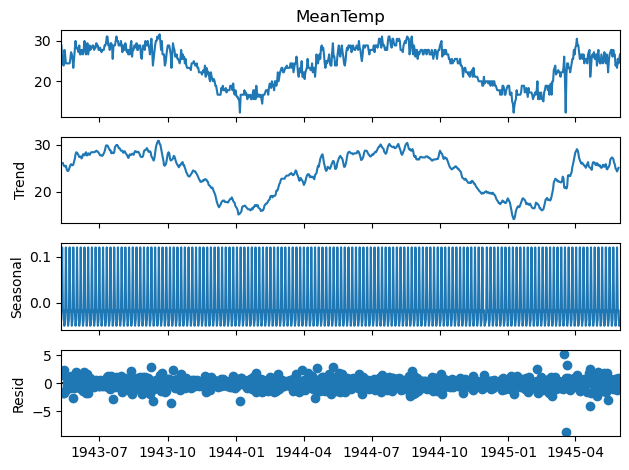

In [176]:
ts_Burma_station_copy = ts_Burma_station.copy()
ts_Burma_station_copy.sort_index(inplace=True)
plot_decompose=seasonal_decompose(ts_Burma_station_copy['MeanTemp'],   period=5)
plot_decompose.plot();

##### Viewing the Rolling mean and standard deviation to check its stationarity

Text(0.5, 1.0, 'Rolling mean & statandard deviation')

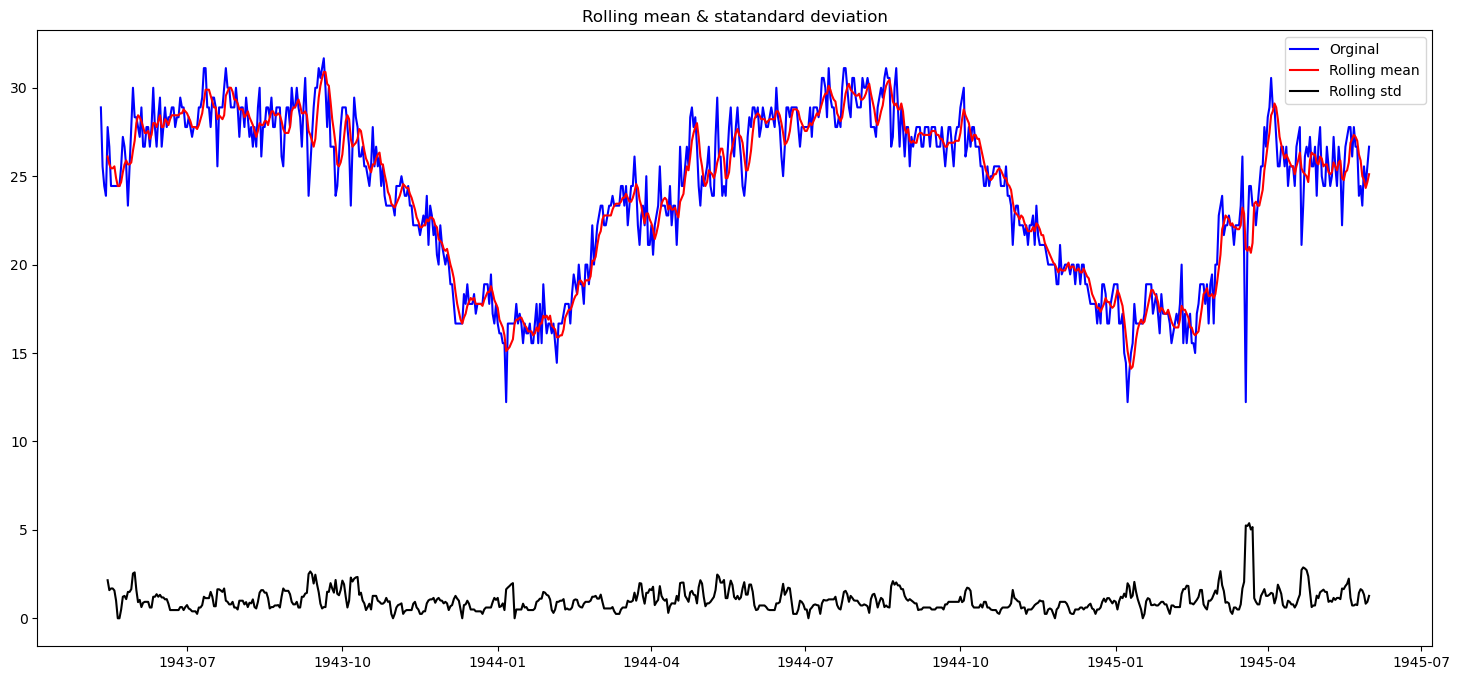

In [180]:
mean_log=ts_Burma_station.rolling(window=5).mean()   
std_log=ts_Burma_station.rolling(window=5).std()
plt.figure(figsize=(18,8))
plt.plot(ts_Burma_station,color='blue',label='Orginal')
plt.plot(mean_log,color='red',label='Rolling mean')
plt.plot(std_log,color='black',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean & statandard deviation')

### Performing AD fuller test for Stationarity testing

H0 : The Time Series is not Stationary

H1 : The Time Seires is Stationary
    
Reject Null Hypothesis : P < 0.05     
Accept Null Hypothesis : P > 0.05     

In [194]:
def check_stationarity(ts):
    result = adfuller(ts)
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
    if result[1] <=0.05:
      print('Stationarity is present')
    else:
      print('No Stationarity')

In [215]:
def plot_ts(ts):   
    rollmean = ts.rolling(window=5).mean()  
    rollstd = ts.rolling(window=5).std()
    plt.figure(figsize=(18,8))
    plt.plot(ts, color = "red",label = "Original")
    plt.plot(rollmean, color='black', label = 'Rolling_mean')
    plt.plot(rollstd, color='green', label = 'Rolling_std')
    plt.title("Mean Temperature of Bindukuri Area")
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.legend()
    plt.show()

#### Making the data Stationary

Many methods are available to make make data stationary. Few of them can be visualized below. We could use any one of these for the ARIMA model

##### 1. Rolling Mean Method

Test statistic:  -1.40959667458877
p-value:  0.5776668028526385
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}
No Stationarity


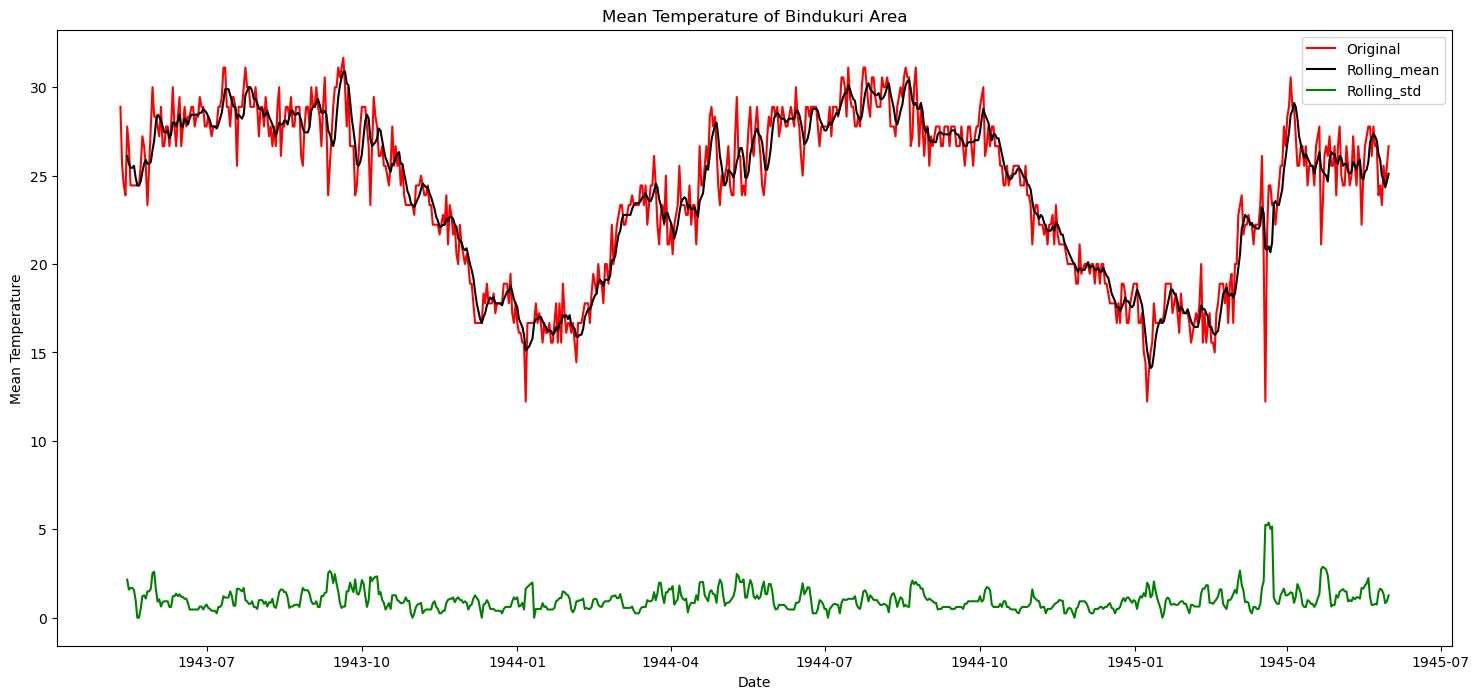

In [216]:
check_stationarity(ts_Burma_station)
plot_ts(ts_Burma_station)

Test statistic:  -11.300451388911918
p-value:  1.3114678901760678e-20
Critical Values: {'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}
Stationarity is present


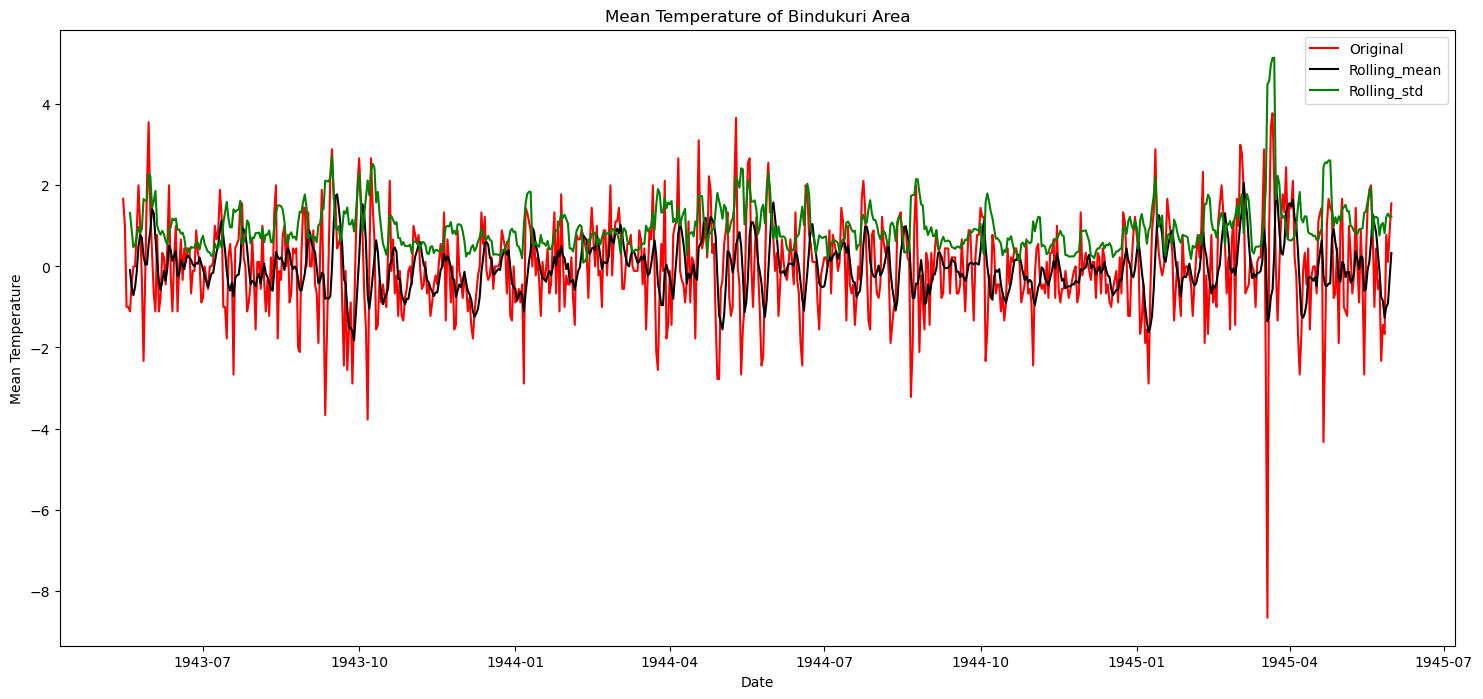

In [221]:
ts_diff = ts_Burma_station - ts_Burma_station.rolling(window=5).mean()  
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)
plot_ts(ts_diff)

##### 2. Differencing

Test statistic:  -11.678955575105393
p-value:  1.7602075693557185e-21
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}
Stationarity is present


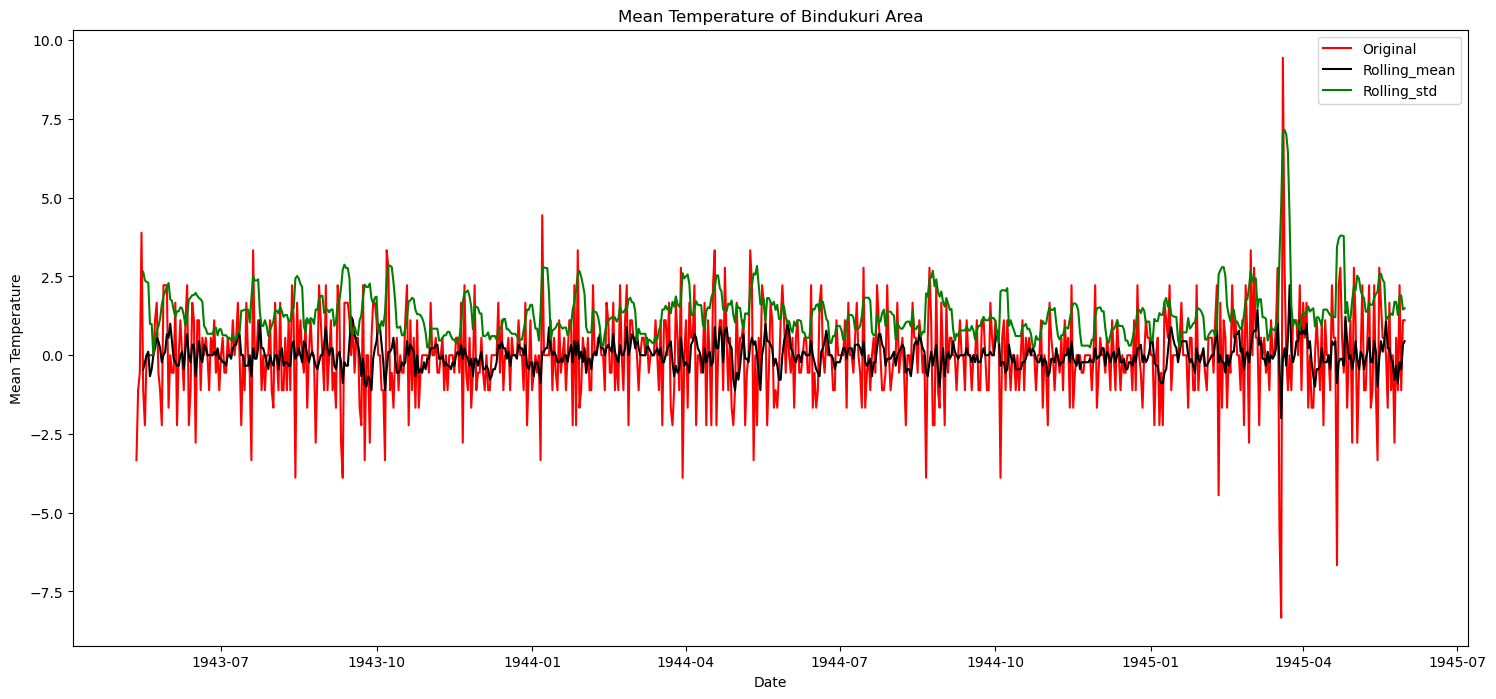

In [222]:
ts_diff = ts_Burma_station - ts_Burma_station.shift()  
ts_diff.dropna(inplace=True)
check_stationarity(ts_diff)
plot_ts(ts_diff)

##### 3. Log Method

##### First order to stabilize Mean

Test statistic:  -1.9663405060036188
p-value:  0.30152375810092125
Critical Values: {'1%': -3.4391580196774494, '5%': -2.8654273226340554, '10%': -2.5688400274762397}
No Stationarity


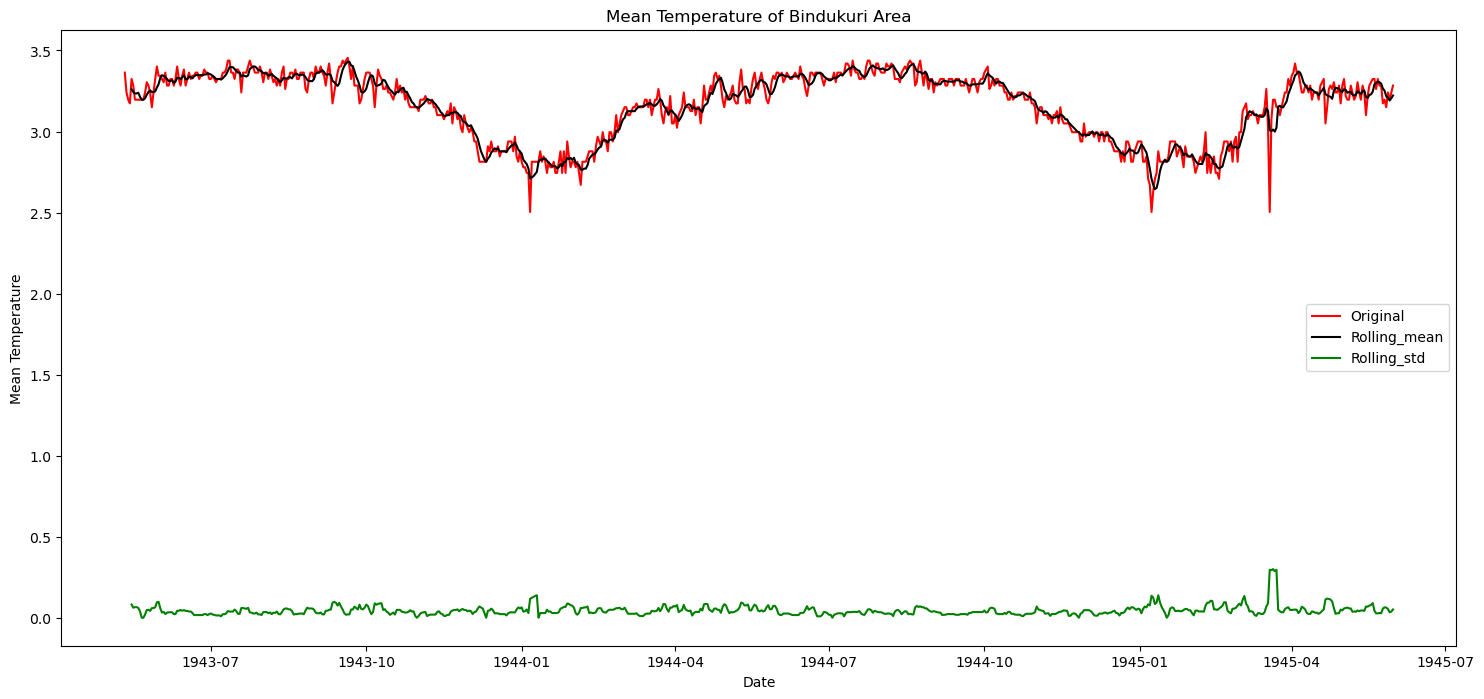

In [296]:
first_log=np.log(ts_Burma_station)
first_log=first_log.dropna()
check_stationarity(first_log)
plot_ts(first_log)

##### Second order to remove seasonality

Test statistic:  -6.81274968553417
p-value:  2.0959872610043918e-09
Critical Values: {'1%': -3.4393644334758475, '5%': -2.8655182850048306, '10%': -2.568888486973192}
Stationarity is present


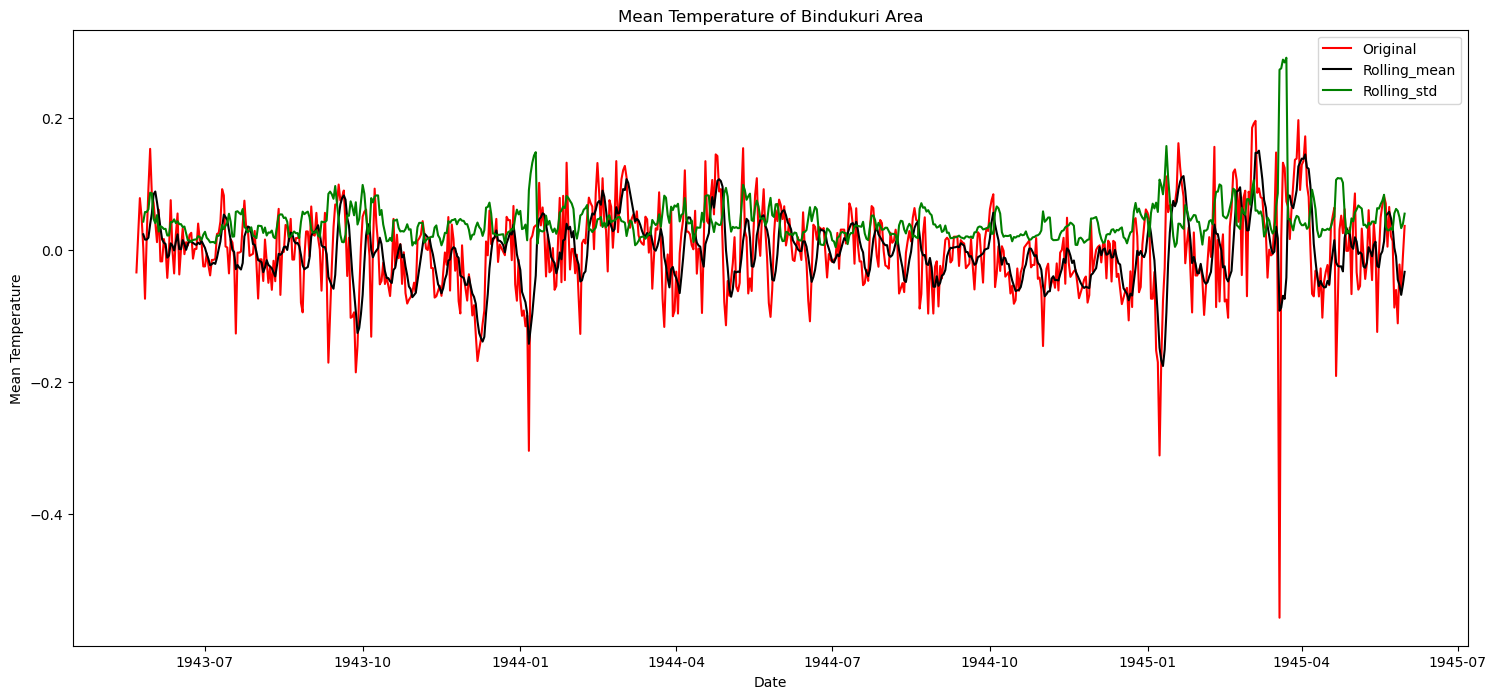

In [225]:
second_log=first_log - first_log.rolling(window=12).mean() 
second_log=second_log.dropna()
check_stationarity(second_log)
plot_ts(second_log)

##### Seasonality & Trend after making data stationary

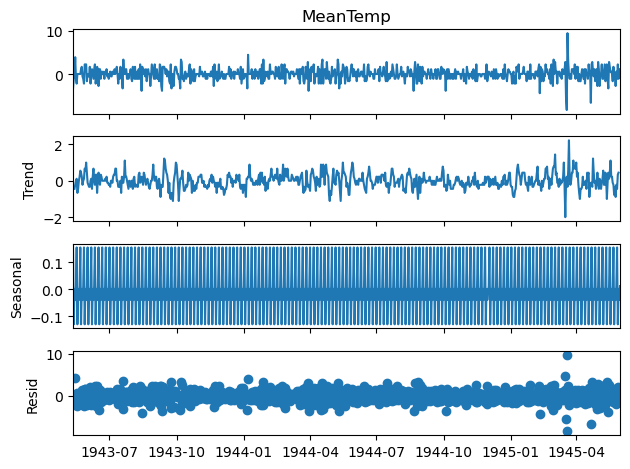

In [228]:
plot_decompose=seasonal_decompose(ts_diff['MeanTemp'],   period=5)
plot_decompose.plot();

##### ACF & PACF

They are every important to understand what model and order the data can be modeled respectively

##### Autocorrelation Function (ACF): 
Measurement of the correlation between time series and lagged version of time series.
##### Partial Autocorrelation Function (PACF): 
This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.

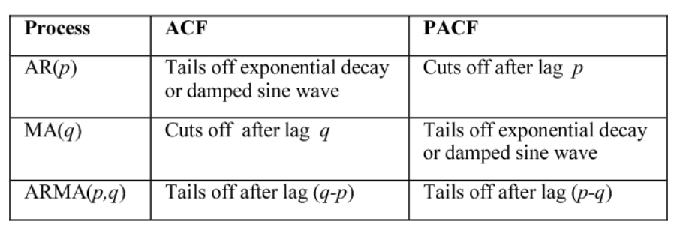

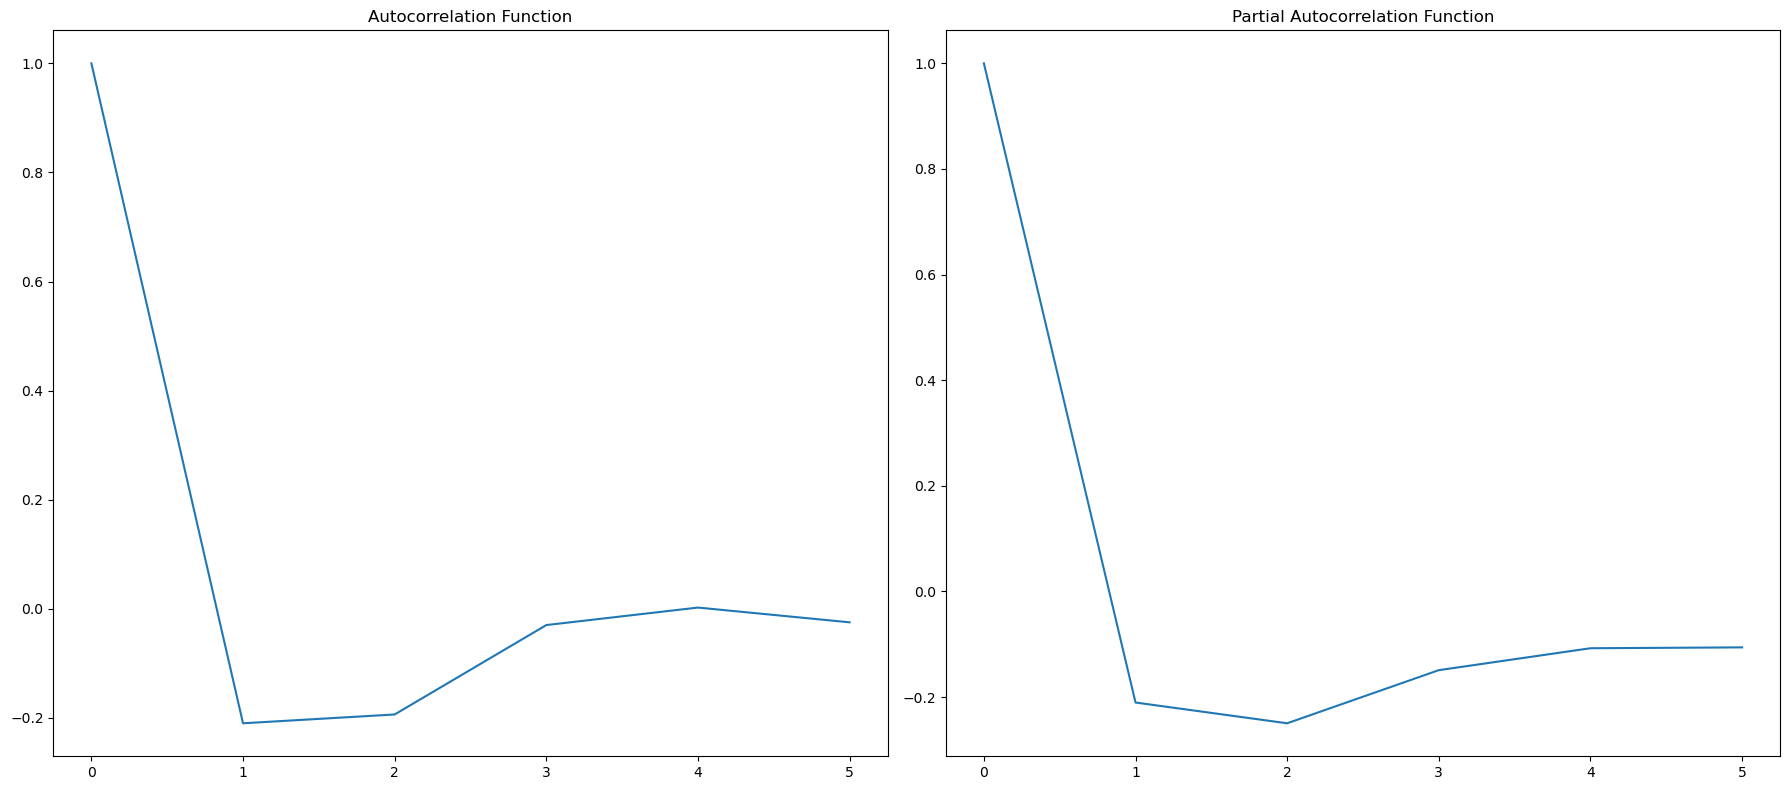

In [280]:
lag_auto_corr = acf(ts_diff,nlags=5)
lag_partial_auto_corr = pacf(ts_diff,nlags=5)

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(lag_auto_corr)
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_partial_auto_corr)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Figure(640x480)
Figure(640x480)


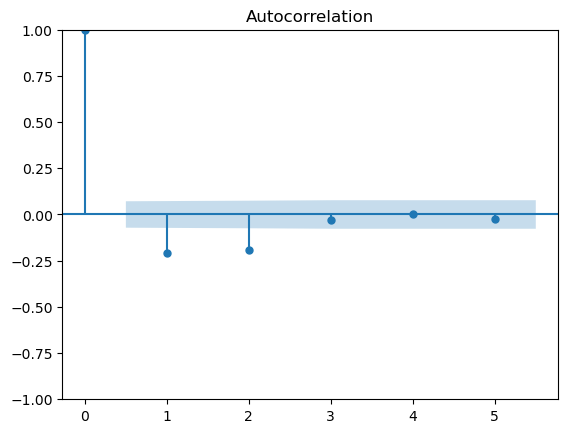

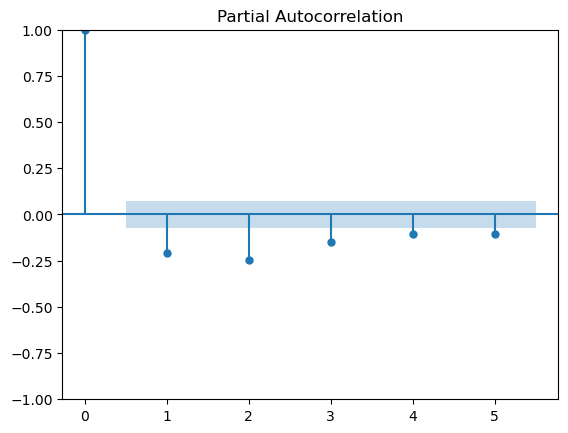

In [286]:
plt_acf = plot_acf(ts_diff.values.squeeze(), lags=5)
plt_pacf = plot_pacf(ts_diff.values.squeeze(), lags=5)
print(plt_acf)
print(plt_pacf)

##### Interpretation

Here if we see the highlighted points are significationaly strongly correlated 

Therefore order of the Model (p,q) could be (1,1) or (2,2)

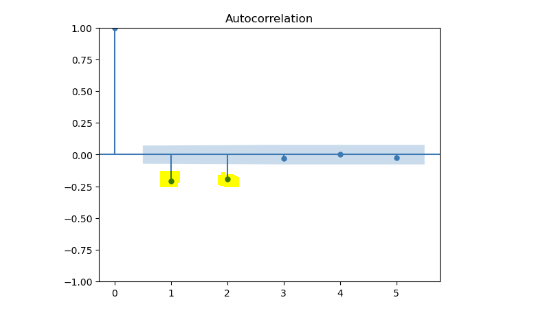,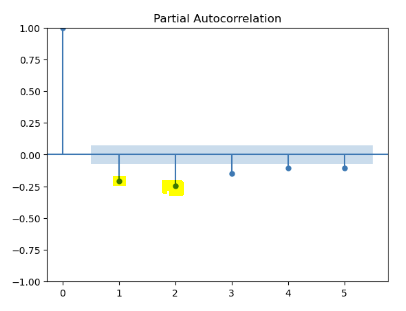

### Cross Validation

In [291]:
mse_scores = []
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(ts_diff):
    train_data, test_data = ts_diff.iloc[train_index], ts_diff.iloc[test_index]
    
    model = ARIMA(train_data, order=(1, 0, 1))   
    fitted_model = model.fit()
 
    predictions = fitted_model.forecast(steps=len(test_data))
  
    mse = mean_squared_error(test_data, predictions)
    mse_scores.append(mse)
 
    print(f'Mean Squared Error for current split: {mse}')
 
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error across all splits: {average_mse}')

Mean Squared Error for current split: 1.5926601299933667
Mean Squared Error for current split: 2.0865447881926293
Mean Squared Error for current split: 1.3669538558459198
Mean Squared Error for current split: 1.0240509849761028
Mean Squared Error for current split: 4.06542025099026
Average Mean Squared Error across all splits: 2.027126001999656


## Build the ARIMA Model

In [287]:
ts_model = ARIMA(ts_Burma_station, order=(1,0,1))
ts_model_fit  = ts_model.fit()

In [283]:
forecast = ts_model_fit.predict()
error = mean_squared_error(ts_Burma_station, forecast)
print('Error: ' ,error)
forecast

Error:  1.7461168199958523


Date
1943-05-11    24.649106
1943-05-12    28.644984
1943-05-13    26.142143
1943-05-14    25.508738
1943-05-15    24.848313
                ...    
1945-05-27    25.269506
1945-05-28    24.212507
1945-05-29    25.593829
1945-05-30    24.593222
1945-05-31    25.460020
Name: predicted_mean, Length: 751, dtype: float64

##### Predictions

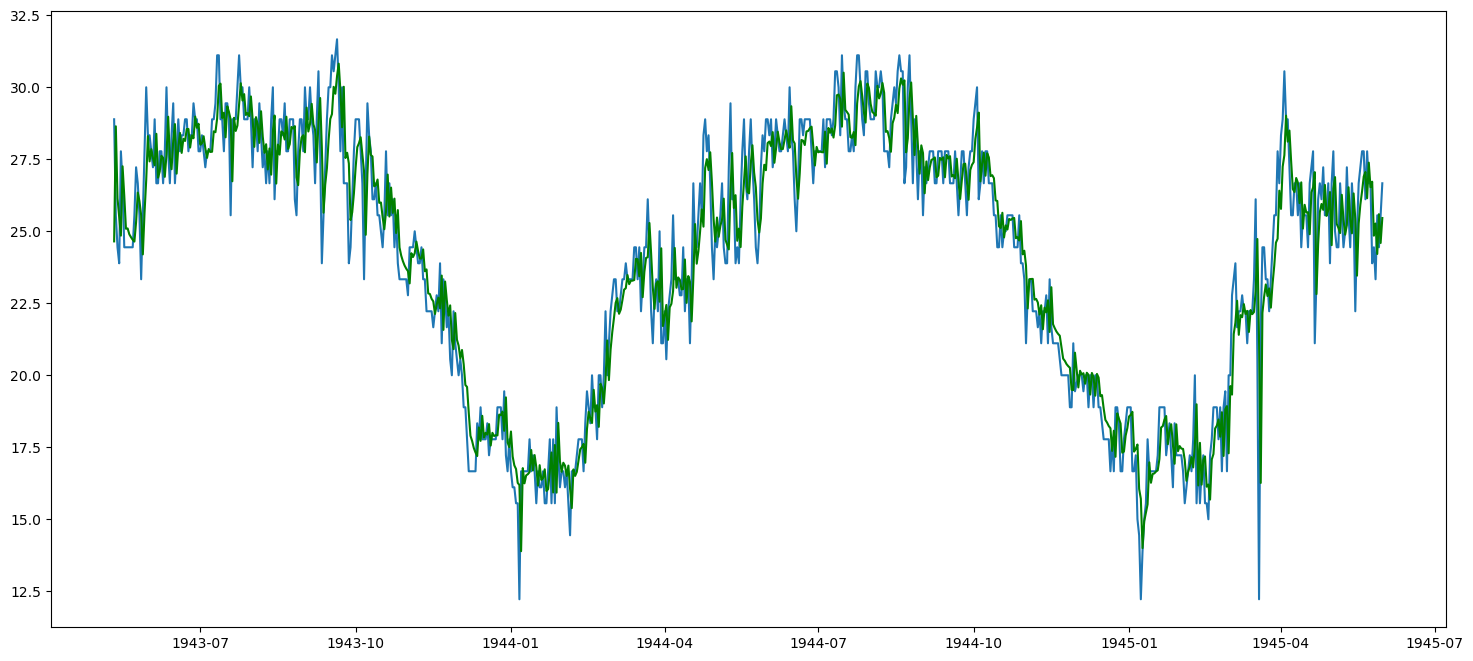

In [284]:
plt.figure(figsize=(18,8))
plt.plot(ts_Burma_station,label='Orginal')
plt.plot(forecast,color='green',label='Predicted')

### References 
https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda

https://www.youtube.com/watch?v=ZE_WGBe0_VU